In [1]:
# Install libraries
!pip install -q diffusers


In [2]:
# Import necessary libraries
import os
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from tqdm.auto import tqdm


In [3]:
# Set device
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Set device
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [5]:
# Install huggingface_hub if not installed
!pip install huggingface_hub

from huggingface_hub import hf_hub_download

# List of all zip filenames you want to download
zip_filenames = ['A.zip','B.zip','C.zip','D.zip','E.zip']

# Download each zip
for zip_file in zip_filenames:
    hf_hub_download(
        repo_id="Mayank022/English_Characters_Images",
        filename=zip_file,
        repo_type="dataset",
        local_dir="./zips"  # Save them inside ./zips
    )


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


A.zip:   0%|          | 0.00/198M [00:00<?, ?B/s]

B.zip:   0%|          | 0.00/210M [00:00<?, ?B/s]

C.zip:   0%|          | 0.00/182M [00:00<?, ?B/s]

D.zip:   0%|          | 0.00/198M [00:00<?, ?B/s]

E.zip:   0%|          | 0.00/166M [00:00<?, ?B/s]

In [6]:
import os
import zipfile

# Paths
zip_folder = "./zips"  # Folder where your zip files are
output_folder = "./character_dataset"  # Folder where you want to extract

# Make sure output folder exists
os.makedirs(output_folder, exist_ok=True)

# Loop through all zip files
for zip_filename in os.listdir(zip_folder):
    if zip_filename.endswith(".zip"):
        # Get the character name (e.g., 'A' from 'A.zip')
        character_name = os.path.splitext(zip_filename)[0]

        # Path to the subfolder where this character's images will go
        character_subfolder = os.path.join(output_folder, character_name)
        os.makedirs(character_subfolder, exist_ok=True)

        # Extract zip
        zip_path = os.path.join(zip_folder, zip_filename)
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(character_subfolder)

print("All zips extracted successfully into 'character_dataset' folder!")


✅ All zips extracted successfully into 'character_dataset' folder!


In [7]:

# Load Character dataset
from torchvision import transforms

# Define the transform
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),    # Resize to (28,28) like MNIST
    transforms.ToTensor(),           # Convert to tensor
])



dataset = ImageFolder(root="./character_dataset/", transform=transform)
print(f"Found {len(dataset)} images belonging to {len(dataset.classes)} classes: {dataset.classes}")


Found 718664 images belonging to 5 classes: ['A', 'B', 'C', 'D', 'E']


In [8]:
# Dataloader
train_dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [9]:
# Mapping class name to index
class_to_idx = dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}
num_classes = len(class_to_idx)


In [10]:
# Define the ClassConditioned UNet
class ClassConditionedUnet(nn.Module):
    def __init__(self, num_classes=num_classes, class_emb_size=4):
        super().__init__()
        self.class_emb = nn.Embedding(num_classes, class_emb_size)
        self.model = UNet2DModel(
            sample_size=28,
            in_channels=1 + class_emb_size,
            out_channels=1,
            layers_per_block=2,
            block_out_channels=(32, 64, 64),
            down_block_types=("DownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D"),
            up_block_types=("AttnUpBlock2D", "AttnUpBlock2D", "UpBlock2D"),
        )

    def forward(self, x, t, class_labels):
        bs, ch, w, h = x.shape
        class_cond = self.class_emb(class_labels)
        class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)
        net_input = torch.cat((x, class_cond), dim=1)
        return self.model(net_input, t).sample

In [11]:

# Initialize scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")


In [12]:

# Initialize model, loss, optimizer
net = ClassConditionedUnet().to(device)
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(net.parameters(), lr=1e-3)
losses = []

In [15]:
# Training loop
n_epochs = 5


In [16]:
for epoch in range(n_epochs):
    for x, y in tqdm(train_dataloader):
        x = x.to(device) * 2 - 1  # Scale to (-1, 1)
        y = y.to(device)

        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 999, (x.shape[0],), device=device).long()
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

        pred = net(noisy_x, timesteps, y)
        loss = loss_fn(pred, noise)

        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())

    avg_loss = sum(losses[-100:]) / 100
    print(f"Finished epoch {epoch}. Avg of last 100 losses: {avg_loss:.6f}")

  0%|          | 0/5615 [00:00<?, ?it/s]

Finished epoch 0. Avg of last 100 losses: 0.027390


  0%|          | 0/5615 [00:00<?, ?it/s]

Finished epoch 1. Avg of last 100 losses: 0.027245


  0%|          | 0/5615 [00:00<?, ?it/s]

Finished epoch 2. Avg of last 100 losses: 0.027540


  0%|          | 0/5615 [00:00<?, ?it/s]

Finished epoch 3. Avg of last 100 losses: 0.026870


  0%|          | 0/5615 [00:00<?, ?it/s]

Finished epoch 4. Avg of last 100 losses: 0.026808


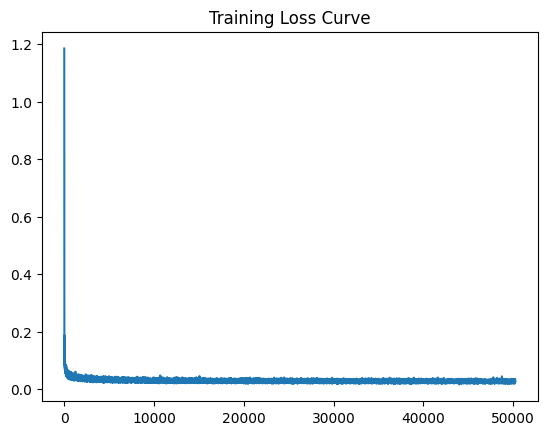

In [17]:
# Plot loss
plt.plot(losses)
plt.title("Training Loss Curve")
plt.show()


Noise shape: torch.Size([40, 1, 28, 28])
Labels shape: torch.Size([40])


  0%|          | 0/1000 [00:00<?, ?it/s]

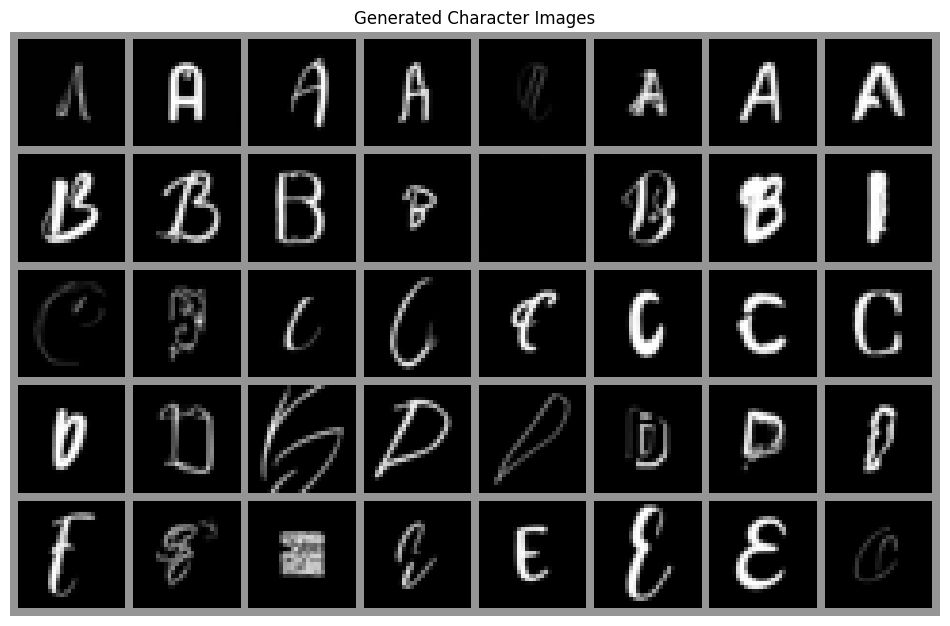

In [21]:
import torch
import torchvision
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

# Set device
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

# Number of classes
num_classes = len(class_to_idx)

# Prepare random noise images + target labels
x = torch.randn(num_classes * 8, 1, 28, 28).to(device)  # now x is 40
label_indices = []

for i in range(num_classes):
    label_indices += [i] * 8  # 8 samples per class

y = torch.tensor(label_indices).to(device)

print(f"Noise shape: {x.shape}")
print(f"Labels shape: {y.shape}")

# Sampling loop
for t in tqdm(noise_scheduler.timesteps):
    with torch.no_grad():
        residual = net(x, t, y)
    x = noise_scheduler.step(residual, t, x).prev_sample

# Show generated samples
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(
    torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=8)[0],
    cmap="Greys"
)
plt.axis('off')
plt.title('Generated Character Images')
plt.show()


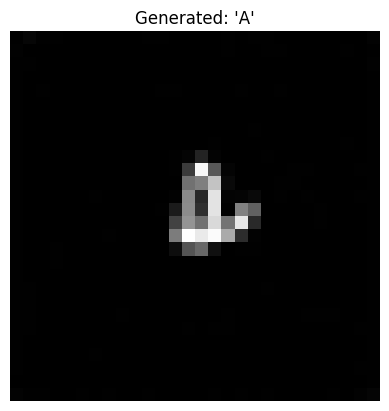

In [29]:
import torch
import torchvision
from matplotlib import pyplot as plt

# Assume the trained model, noise_scheduler, class_to_idx are already loaded

# Function to generate character
def generate_character(model, noise_scheduler, class_to_idx, character, device="cuda"):
    model.eval()

    # Map character to class index
    if character not in class_to_idx:
        raise ValueError(f"Character '{character}' not found in classes: {list(class_to_idx.keys())}")
    char_idx = class_to_idx[character]

    # Prepare noise and label
    x = torch.randn(1, 1, 28, 28).to(device)  # Start from random noise
    y = torch.tensor([char_idx]).to(device)   # Conditioning label

    # Sampling loop
    for t in noise_scheduler.timesteps:
        with torch.no_grad():
            residual = model(x, t, y)
        x = noise_scheduler.step(residual, t, x).prev_sample

    # Final image
    x = x[0][0].detach().cpu().clip(-1, 1)  # Shape: (28, 28)

    return x

# Example usage:

# Input your character here (must match one of the folders e.g., 'A', 'B', 'C', etc.)
input_character = "A"

# Generate image
generated_image = generate_character(net, noise_scheduler, class_to_idx, input_character, device)

# Show the image
plt.imshow(generated_image, cmap="Greys")
plt.title(f"Generated: '{input_character}'")
plt.axis('off')
plt.show()


In [30]:
import torch
import matplotlib.pyplot as plt

def generate_and_display(model, noise_scheduler, class_to_idx, input_character, device="cuda"):
    """
    Takes a character (e.g., 'A'), generates the corresponding image, and displays it.
    """

    # Generate the image
    generated_image = generate_character(model, noise_scheduler, class_to_idx, input_character, device)

    # Display the generated image
    plt.imshow(generated_image, cmap="Greys")
    plt.title(f"Generated: '{input_character}'")
    plt.axis('off')
    plt.show()


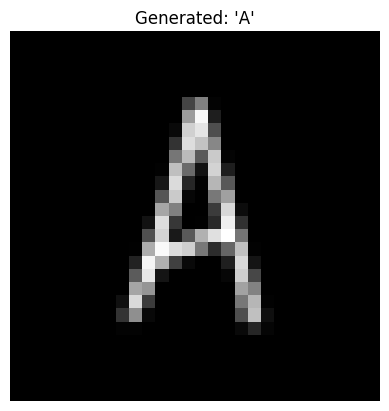

In [31]:
generate_and_display(net, noise_scheduler, class_to_idx, "A", device)


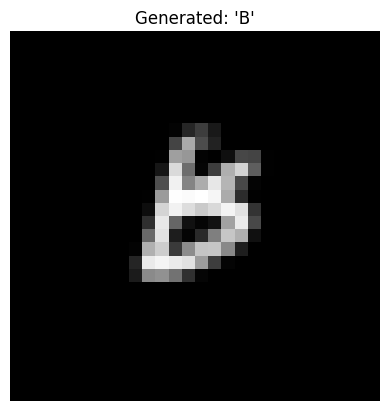

In [32]:
generate_and_display(net, noise_scheduler, class_to_idx, "B", device)


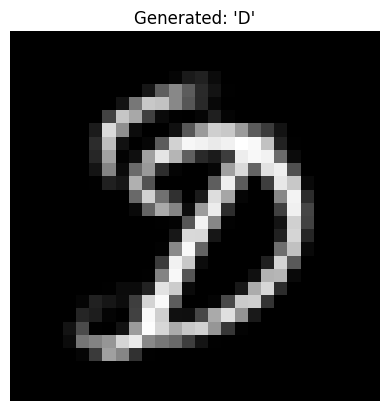

In [33]:
generate_and_display(net, noise_scheduler, class_to_idx, "D", device)


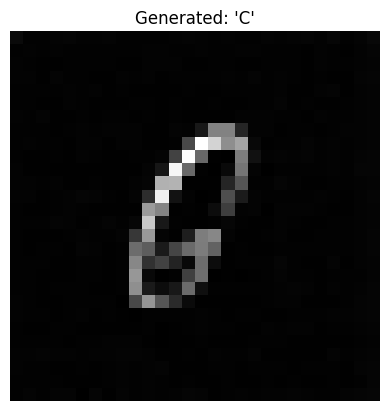

In [34]:
generate_and_display(net, noise_scheduler, class_to_idx, "C", device)


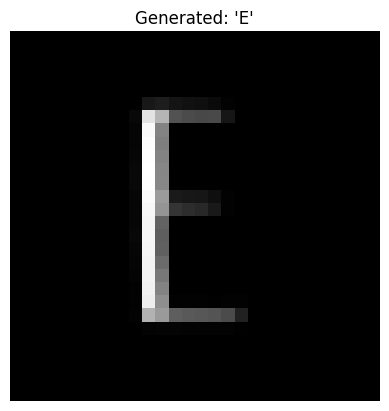

In [35]:
generate_and_display(net, noise_scheduler, class_to_idx, "E", device)
